# Evaluate Face Aligner

In [1]:
import os
import re
import cv2
import time
import numpy as np
import subprocess
import multiprocessing
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

np.random.seed(11)



## Load Testset

You **need to download**:
* 300W dataset (2GB, [링크](https://ibug.doc.ic.ac.uk/resources/300-W/))

You **need to change**:
* Path of *DATA_PATH* directory in `DATA_PATH`
* Margin of face image in `margin`

Cropped face image is calculated from the landmark position

In [2]:
from math import *

# Change here ###################################
DATA_PATH = '/home/jovyan/Dataset/300W'  # directory 맨 앞에 '/' 없으면 오류남..
margin = 0.0
#################################################

X, Y = [], []

"""
face: list of int, (4)
    position of face bounding box
    (left, top, right, bottom) == (x1, y1, x2, y2)

landmarks: list of int, (10)
    position of facial 5 landmarks
    (center of left eye, center of right eye, top of nose, left corner of mouth, right corner of mouth)
"""

file_format = DATA_PATH + '/01_Indoor/indoor_{index:03d}'  # 0을 왼쪽에 패딩해서 세자리 맞추기. 1-> 001
for i in tqdm(range(1, 301), desc='Indoor'):
    # load image
    image = cv2.imread(file_format.format(index=i) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # load landmark
    pts = file_format.format(index=i) + '.pts'
    with open(pts, 'r') as f:
        f.readline()
        f.readline()
        f.readline()

        landmarks = []
        for _ in range(68):
            line = f.readline().split()
            line = list(map(lambda x: float(x), line))
            landmarks.append(line)

    # Change here ###################################
    # calculate bbox of face
    # if you want to get the bbox in another way, 
    # please delete the code below and fill in your code
    """x_min, y_min = np.min(landmarks, axis=0).astype(np.int32)
    x_max, y_max = np.max(landmarks, axis=0).astype(np.int32)
    width, height = x_max - x_min + 1, y_max - y_min + 1
    x_center, y_center = (x_min + width/2).astype(np.int32), (y_min + height/2).astype(np.int32)
    
    boxsize = int(max(width, height)*1.2)
    x_1, y_1 = x_center - boxsize//2, y_center - boxsize//2
    x2, y2 = x_1 + boxsize, y_1 + boxsize
    x1, y1 = max(0, x_1), max(0, y_1)
    h, w, _ = image.shape
    x2, y2 = min(w, x2), min(h, y2)

    imgT = image[y1:y2, x1:x2,]
    imgT = cv2.resize(imgT, (112, 112))
    
    xy = [x_1, y_1]
    landmark = (landmarks - xy)/boxsize"""
    
    xy = np.min(landmarks, axis=0).astype(np.int32)
    zz = np.max(landmarks, axis=0).astype(np.int32)
    wh = zz- xy + 1
    
    center = (xy + wh/2).astype(np.int32)
    boxsize = int(max(wh) * 1.2)
    xy = center - boxsize//2
    x1, y1 = xy
    x2, y2 = xy + boxsize
    img = cv2.imread(file_format.format(index=i) + '.png')
    height, width, _ = img.shape
    dx = max(0, -x1)
    dy = max(0, -y1)
    x1 = max(0, x1)
    y1 = max(0, y1)
    
    edx = max(0, x2 - width)
    edy = max(0, y2 - height)
    x2 = min(width, x2)
    y2 = min(height, y2)
    
    imgT = img[y1:y2, x1:x2]
    
    imgT = cv2.resize(imgT, (112, 112))
    landmark = (landmarks -xy)/boxsize
    
    
    """for i in range(len(landmarks)):
        landmarks[i][0] -= x1
        landmarks[i][1] -= y1 """
    #################################################
    
    X.append(imgT)
    Y.append(landmark)

file_format = DATA_PATH + '/02_Outdoor/outdoor_{index:03d}'
for i in tqdm(range(1, 301), desc='Outdoor'):
    # load image
    image = cv2.imread(file_format.format(index=i) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # load landmark
    pts = file_format.format(index=i) + '.pts'
    with open(pts, 'r') as f:
        f.readline()
        f.readline()
        f.readline()

        landmarks = []
        for _ in range(68):
            line = f.readline().split()
            line = list(map(lambda x: float(x), line))
            landmarks.append(line)

    # Change here ###################################
    # calculate bbox of face
    # if you want to get the bbox in another way, 
    # please delete the code below and fill in your code
    """x_min, y_min = np.min(landmarks, axis=0)
    x_max, y_max = np.max(landmarks, axis=0)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    x1 = int(max(0, x_center - (width * (1 + margin)) / 2))
    y1 = int(max(0, y_center - (height * (1 + margin)) / 2))
    x2 = int(min(image.shape[1], x_center + (width * (1 + margin)) / 2))
    y2 = int(min(image.shape[0], y_center + (height * (1 + margin)) / 2))

    face = image[y1:y2, x1:x2, :]

    for i in range(len(landmarks)):
        landmarks[i][0] -= x1
        landmarks[i][1] -= y1"""
    
    xy = np.min(landmarks, axis=0).astype(np.int32)
    zz = np.max(landmarks, axis=0).astype(np.int32)
    wh = zz - xy + 1
    
    center = (xy + wh/2).astype(np.int32)
    img = cv2.imread(file_format.format(index=i) + '.png')
    boxsize = int(np.max(wh) * 1.2)
    xy = center - boxsize//2
    x1, y1 = xy
    x2, y2 = xy + boxsize
    height, width, _ = img.shape
    dx = max(0, -x1)
    dy = max(0, -y1)
    x1 = max(0, x1)
    y1 = max(0, y1)
    
    x2 = min(width, x2)
    y2 = min(height, y2)
    
    imgT = img[y1:y2, x1:x2]
    imgT = cv2.resize(imgT, (112, 112))
    
    landmark = (landmarks - xy)/boxsize
    
    #################################################
    
    X.append(imgT)
    Y.append(landmark)

Outdoor: 100%|██████████| 300/300 [00:55<00:00,  5.41it/s]


### Test Data Example

X: numpy array, RGB image  
Y: list of float, pixel position of landmark

## Define Model (Optional)

For evaluation process reasons, model implementation and instantiation must be done separately.  
**You need to define** your model by
* Import package
* Define model class which contains pre/post process

In [3]:
# Change here ###################################
# Define your model (if unnecessary, you can ignore it)

import torch
import torch.nn as nn
import math


def conv_bn(inp, oup, kernel, stride, padding=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel, stride, padding, bias=False),
        nn.BatchNorm2d(oup), nn.ReLU(inplace=True))


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, use_res_connect, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        self.use_res_connect = use_res_connect

        self.conv = nn.Sequential(
            nn.Conv2d(inp, inp * expand_ratio, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU(inplace=True),
            nn.Conv2d(inp * expand_ratio,
                      inp * expand_ratio,
                      3,
                      stride,
                      1,
                      groups=inp * expand_ratio,
                      bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU(inplace=True),
            nn.Conv2d(inp * expand_ratio, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class PFLDInference(nn.Module):
    def __init__(self):
        super(PFLDInference, self).__init__()

        self.conv1 = nn.Conv2d(3,
                               64,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(64,
                               64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.conv3_1 = InvertedResidual(64, 64, 2, False, 2)

        self.block3_2 = InvertedResidual(64, 64, 1, True, 2)
        self.block3_3 = InvertedResidual(64, 64, 1, True, 2)
        self.block3_4 = InvertedResidual(64, 64, 1, True, 2)
        self.block3_5 = InvertedResidual(64, 64, 1, True, 2)

        self.conv4_1 = InvertedResidual(64, 128, 2, False, 2)

        self.conv5_1 = InvertedResidual(128, 128, 1, False, 4)
        self.block5_2 = InvertedResidual(128, 128, 1, True, 4)
        self.block5_3 = InvertedResidual(128, 128, 1, True, 4)
        self.block5_4 = InvertedResidual(128, 128, 1, True, 4)
        self.block5_5 = InvertedResidual(128, 128, 1, True, 4)
        self.block5_6 = InvertedResidual(128, 128, 1, True, 4)

        self.conv6_1 = InvertedResidual(128, 16, 1, False, 2)  # [16, 14, 14]

        self.conv7 = conv_bn(16, 32, 3, 2)  # [32, 7, 7]
        self.conv8 = nn.Conv2d(32, 128, 7, 1, 0)  # [128, 1, 1]
        self.bn8 = nn.BatchNorm2d(128)

        self.avg_pool1 = nn.AvgPool2d(14)
        self.avg_pool2 = nn.AvgPool2d(7)
        self.fc = nn.Linear(176, 196)

    def forward(self, x):  # x: 3, 112, 112
        x = self.relu(self.bn1(self.conv1(x)))  # [64, 56, 56]
        x = self.relu(self.bn2(self.conv2(x)))  # [64, 56, 56]
        x = self.conv3_1(x)
        x = self.block3_2(x)
        x = self.block3_3(x)
        x = self.block3_4(x)
        out1 = self.block3_5(x)

        x = self.conv4_1(out1)
        x = self.conv5_1(x)
        x = self.block5_2(x)
        x = self.block5_3(x)
        x = self.block5_4(x)
        x = self.block5_5(x)
        x = self.block5_6(x)
        x = self.conv6_1(x)
        x1 = self.avg_pool1(x)
        x1 = x1.view(x1.size(0), -1)

        x = self.conv7(x)
        x2 = self.avg_pool2(x)
        x2 = x2.view(x2.size(0), -1)

        x3 = self.relu(self.conv8(x))
        x3 = x3.view(x3.size(0), -1)

        multi_scale = torch.cat([x1, x2, x3], 1)
        landmarks = self.fc(multi_scale)

        return out1, landmarks


class AuxiliaryNet(nn.Module):
    def __init__(self):
        super(AuxiliaryNet, self).__init__()
        self.conv1 = conv_bn(64, 128, 3, 2)
        self.conv2 = conv_bn(128, 128, 3, 1)
        self.conv3 = conv_bn(128, 32, 3, 2)
        self.conv4 = conv_bn(32, 128, 7, 1)
        self.max_pool1 = nn.MaxPool2d(3)
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.max_pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x



    

#################################################

In [4]:
import torch.backends.cudnn as cudnn
import easydict


cudnn.benchmark = True
cudnn.determinstic = True
cudnn.enabled = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


args = easydict.EasyDict({
    "model_path" : "./checkpoint/snapshot/checkpoint.pth.tar",
    "test_dataset" : './data/test_data/list.txt',
    "show_image" : False
})


checkpoint = torch.load(args.model_path, map_location=device)
pfld_backbone = PFLDInference().to(device)
pfld_backbone.load_state_dict(checkpoint['pfld_backbone'])


<All keys matched successfully>

## Evaluate

Evaluation Method:
* **NME**: Normalized Mean Error, mean of euclidean distance which normalized by eye corner
* **FPS**: Calculate clock time between execution, get mean value of time intervals
* **VRAM**: Run subprocess which periodically call *nvidia-smi* and grep memory usage, use gap between before loading and peak value

Model should be allocated to GPU after `monitor.start()`

In this evaluation code, we only interested in NME of **5 landmarks**  
(center of left eye, center of right eye, top of nose, left corner of mouth, right corner of mouth)  
The code below shows how to get 5 landmarks from 68 landmarks  

In [5]:
def calculate_nme(predicts, labels):
    nmes = []
    for predict, label in zip(predicts, labels):
        landmarks_X = np.array(predict).reshape(98,2)
        landmarks_Y = np.array(label)
        corner = np.linalg.norm(landmarks_Y[36] - landmarks_Y[45])
        landmark5_X = np.zeros((5, 2), dtype=np.float32)
        landmark5_Y = np.zeros((5, 2), dtype=np.float32)
        # landmark5[0]: 왼쪽 눈동자, landmark5[1]: 오른쪽 눈동자, landmark5[2]: 코 끝, landmark5[3]: 왼쪽 입술 끝, landmark5[4]: 오른 입술 끝
        landmark5_Y[0] = (landmarks_Y[36] + landmarks_Y[39]) / 2    
        landmark5_Y[1] = (landmarks_Y[42] + landmarks_Y[45]) / 2
        landmark5_Y[2] = landmarks_Y[30]
        landmark5_Y[3] = landmarks_Y[48]
        landmark5_Y[4] = landmarks_Y[54]
        landmark5_X[0] = (landmarks_X[60] + landmarks_X[64]) / 2
        landmark5_X[1] = (landmarks_X[68] + landmarks_X[72]) / 2
        landmark5_X[2] = landmarks_X[54]
        landmark5_X[3] = landmarks_X[76]
        landmark5_X[4] = landmarks_X[82]
        
        dist = np.linalg.norm(landmark5_X - landmark5_Y, axis=1)
        dist = np.mean(dist)
        nmes.append(dist / corner)
    
    return nmes

In [6]:
class Monitor(multiprocessing.Process):
    def __init__(self, delay=0.1, gpu_index=0, history_dict=None):
        super(Monitor, self).__init__()
        self.delay = delay # Time between calls to GPUtil
        self.gpu_index = gpu_index
        self.max_vram = 0
        self.history_dict = history_dict
        
    def run(self):
        while not self.history_dict['stop'].value:
            info = subprocess.check_output('nvidia-smi --query-gpu=memory.used --format=csv', shell=True)
            self.max_vram = max(self.max_vram, (int(re.findall('(\d+) MiB', str(info).split('\\n')[self.gpu_index+1])[0])))
            time.sleep(self.delay)
        self.history_dict['mem'].value = self.max_vram
        
    def stop(self):
        self.history_dict['stop'].value = True

You **need to**:
* assign your model to `model`
* fill dummy execution code
* fill evaluation code according to variable format

In [7]:
import copy

from torchvision import transforms


nmes, exec_times, vrams = [], [], []

manager = multiprocessing.Manager()
history_dict = manager.dict({'mem':manager.Value('i', 0), 'stop':manager.Value('i', False)})
monitor = Monitor(0.5, 0, history_dict)

info = subprocess.check_output('nvidia-smi --query-gpu=memory.used --format=csv', shell=True)
prev_gpu = int(str(info).split('\\n')[1].split()[0])

monitor.start()
# Change here ###################################
# Load your model
model = pfld_backbone
pfld_backbone.eval()

## resizing X to 112*112 (ok) and transform to tensor
## X의 요소요소마다 transform하도록 수정

# X = transforms.Compose([transforms.ToTensor()])(X)
X_tensor = []

for x in X:
    X_tensor.append(transforms.Compose([transforms.ToTensor()])(x))


## 인풋으로 이미지/ndarray로 변환해서 넣어주어야 함.


# dummy execution for escape initialize overhead
# for _ in range(10):
#    _ = pfld_backbone(X_tensor)
#################################################

"""
landmarks: list of int, (batch, num_faces, 10)
    position of facial 5 landmarks
    (center of left eye, center of right eye, top of nose, left corner of mouth, right corner of mouth) 
"""
landmarks = []

for x, y in tqdm(zip(X_tensor, Y), total=600):
    stime = time.time()
    # Change here ###################################
    
    # resizing image to 112 * 112
    x = x.to(device)
    
    _, landmark = pfld_backbone(x.unsqueeze(0))
    
#    landmark = landmark.numpy()
    landmark = landmark.reshape(landmark.shape[0], -1 ,2)
    
#    landmarks.append(landmark)
# https://mirae-kim.tistory.com/52 참고.
    landmarks.append(landmark.tolist())        # CUDA memory 문제 해결.
    
    
    #################################################
    etime = time.time()
    exec_times.append(etime - stime)

monitor.stop()
monitor.join()

result = calculate_nme(landmarks, Y)
nmes.append(result)

100%|██████████| 600/600 [00:02<00:00, 259.99it/s]


## Result

In [8]:
print(f"NME : {np.mean(nmes[0])*100:5.2f} %")
print(f"FPS : {1 / np.mean(exec_times):5.0f} image/s")
print(f"VRAM: {history_dict['mem'].value - prev_gpu:5.0f} MB")

NME :  5.27 %
FPS :   263 image/s
VRAM:   210 MB


## Visualize Results

Green dot: Ground Truth  
Red dot: Predict

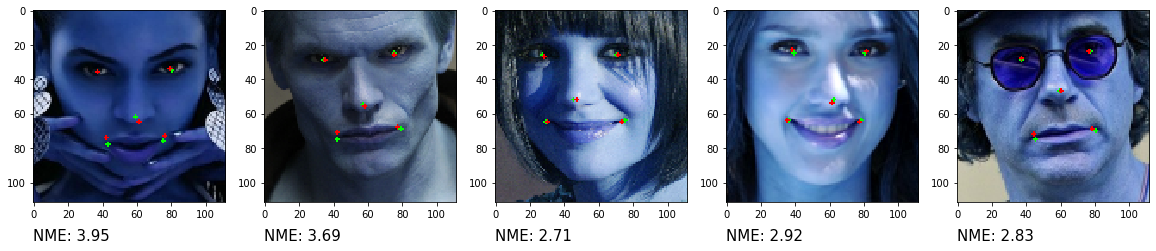

In [9]:
fig = plt.figure(figsize=(20, 5))

subplot = 0
for index in [0, 1, 2, 301, 305]:
    image = X[index].copy()
    
    landmarks_X = np.array(landmarks[index]).reshape(98,2)
    landmark5_X = np.zeros((5, 2), dtype=np.float32)
    landmark5_X[0] = (landmarks_X[60] + landmarks_X[64]) / 2
    landmark5_X[1] = (landmarks_X[68] + landmarks_X[72]) / 2
    landmark5_X[2] = landmarks_X[54]
    landmark5_X[3] = landmarks_X[76]
    landmark5_X[4] = landmarks_X[82]
    
    landmarks_Y = np.array(Y[index])
    landmark5_Y = np.zeros((5, 2), dtype=np.float32)
    landmark5_Y[0] = (landmarks_Y[36] + landmarks_Y[39]) / 2    
    landmark5_Y[1] = (landmarks_Y[42] + landmarks_Y[45]) / 2
    landmark5_Y[2] = landmarks_Y[30]
    landmark5_Y[3] = landmarks_Y[48]
    landmark5_Y[4] = landmarks_Y[54]
    
    radius = image.shape[1] // 150 + 1

    for i in range(5):
        x, y = landmark5_Y[i]
        x, y = int(x*112), int(y*112)
        cv2.circle(image, (x, y), radius, (0, 255, 0), -1)
        
    for i in range(5):
        x, y = landmark5_X[i]
        x, y = int(x*112), int(y*112)
        cv2.circle(image, (x, y), radius, (255, 0, 0), -1)
    
    subplot += 1
    ax = fig.add_subplot(1, 5, subplot)
    ax.text(0, -0.2, f'NME: {nmes[0][index]*100:.2f}', fontsize=15, transform=ax.transAxes)
    ax.imshow(image)